In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
import json
import pandas as pd
data_file = open("./drive/MyDrive/yelp_academic_dataset_review.json")
data = []
for line in data_file:
    data.append(json.loads(line))
review_df = pd.DataFrame(data)
data_file.close()
review_df=review_df.drop(["review_id","user_id","business_id","useful","funny","cool","date"],axis=1)
d={1.0:"neg",2.0:"neg",3.0:"neu",4.0:"pos",5.0:"pos"}
for idx in review_df.index:
    review_df["stars"][idx]=d[review_df["stars"][idx]]
review_df.rename(columns = {'stars':'sentiment'}, inplace = True)
df=review_df
df.head()

<ipython-input-2-6ad443c123a4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df["stars"][idx]=d[review_df["stars"][idx]]
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,sentiment,text
0,neu,"If you decide to eat here, just be aware it is..."
1,pos,I've taken a lot of spin classes over the year...
2,neu,Family diner. Had the buffet. Eclectic assortm...
3,pos,"Wow! Yummy, different, delicious. Our favo..."
4,pos,Cute interior and owner (?) gave us tour of up...


In [ ]:
pos_df=df[df.sentiment=="pos"]
neg_df=df[df.sentiment=="neg"]
neu_df=df[df.sentiment=="neu"]
print(pos_df.size)
print(neg_df.size)
my_pos=pos_df[:23803*2]
my_neg=neg_df[:14098*2]
my_neu=neu_df[:10005*2]
print(my_pos.size)
print(my_neg.size)
my_df=pd.concat([my_pos, my_neg,my_neu])
print(my_df.size)

9369090
3227602
95212
56392
191624


In [ ]:
#my_df.head()
final_df=my_df.sample(frac=1)
final_df.head()
final_df.to_csv("my_review.csv")

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='out_3.csv')  
final_df.to_csv('./drive/MyDrive/out_3.zip', index=False,
          compression=compression_opts) 

In [ ]:
t=final_df[final_df.sentiment=="neg"]
t.size

56392

In [ ]:
final_df.head()

,sentiment,text
9653,pos,Great service and phenomenal dessert. The gooe...
51224,pos,"Ok, so I have no reason to go to this hotel be..."
5395,pos,"As expected, the donuts were AMAZING. My husba..."
2454,pos,The best Beignet's. Hands down. This great sho...
41976,pos,If you can get an egg on it... get an egg on i...


In [ ]:
df=pd.read_csv('./drive/MyDrive/out.csv')
#df=df[:20000]


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


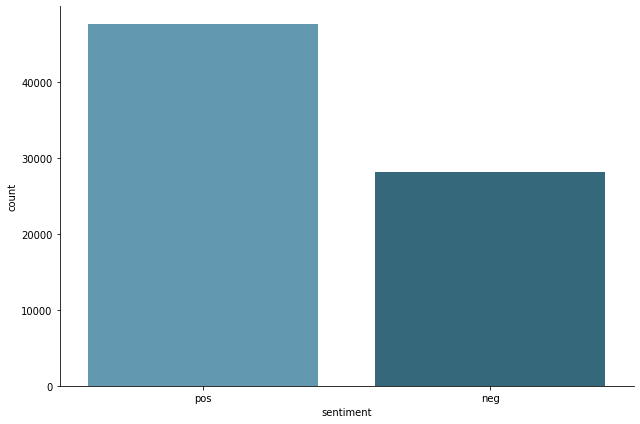

In [ ]:
sns.factorplot(x="sentiment", data=df, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [ ]:
X = df.text
Y = df.sentiment
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1)

In [ ]:
Y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
from keras.utils import pad_sequences
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [ ]:
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [ ]:
def model_attention_applied_after_lstm():
    #inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [ ]:
#from keras.layers import merge
from keras.layers import multiply
from keras.layers.core import *
#from keras.layers.recurrent import LSTM
from keras.models import *

from keras.utils.vis_utils import plot_model

In [ ]:
INPUT_DIM = 50
TIME_STEPS = max_len

In [ ]:
m = model_attention_applied_after_lstm()
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 50)      50000       ['inputs[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, 150, 64)      29440       ['embedding[0][0]']              
                                                                                                  
 permute (Permute)              (None, 64, 150)      0           ['lstm[0][0]']                   
                                                                                              

In [ ]:
import tensorflow as tf

In [ ]:
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
# metrics=[tf.keras.metrics.Accuracy(),
# tf.keras.metrics.Precision(),
# tf.keras.metrics.Recall(),
# tf.keras.metrics.AUC()
# ]
)
# history=m.fit(sequences_matrix,Y_train,batch_size=128,epochs=300,
#            validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
history=m.fit(sequences_matrix,Y_train,batch_size=128,epochs=15,
          validation_split=0.2)

Epoch 1/15
427/427 [==============================] - 17s 34ms/step - loss: 0.3491 - accuracy: 0.8420 - recall_7: 0.9341 - precision_7: 0.8341 - val_loss: 0.1989 - val_accuracy: 0.9255 - val_recall_7: 0.9430 - val_precision_7: 0.9393
Epoch 2/15
427/427 [==============================] - 14s 33ms/step - loss: 0.1873 - accuracy: 0.9282 - recall_7: 0.9433 - precision_7: 0.9423 - val_loss: 0.1733 - val_accuracy: 0.9315 - val_recall_7: 0.9338 - val_precision_7: 0.9567
Epoch 3/15
427/427 [==============================] - 14s 33ms/step - loss: 0.1714 - accuracy: 0.9330 - recall_7: 0.9480 - precision_7: 0.9455 - val_loss: 0.1645 - val_accuracy: 0.9362 - val_recall_7: 0.9553 - val_precision_7: 0.9444
Epoch 4/15
427/427 [==============================] - 14s 33ms/step - loss: 0.1573 - accuracy: 0.9380 - recall_7: 0.9504 - precision_7: 0.9508 - val_loss: 0.1524 - val_accuracy: 0.9405 - val_recall_7: 0.9513 - val_precision_7: 0.9544
Epoch 5/15
427/427 [==============================] - 14s 32ms/s

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)
accr = m.evaluate(test_sequences_matrix,Y_test)
print(accr)
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

237/237 [==============================] - 2s 9ms/step - loss: 0.1767 - accuracy: 0.9406 - recall_7: 0.9646 - precision_7: 0.9415
[0.17670704424381256, 0.9406411051750183, 0.9646336436271667, 0.9415047764778137]


In [ ]:
from sklearn.metrics import classification_report
y_pred=m.predict(test_sequences_matrix)

y_pred[y_pred<0.5]=0
y_pred[y_pred>=0.5]=1
print(y_pred)
print(Y_test)
print(classification_report(Y_test,y_pred))

237/237 [==============================] - 2s 8ms/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2859
           1       0.94      0.96      0.95      4722

    accuracy                           0.94      7581
   macro avg       0.94      0.93      0.94      7581
weighted avg       0.94      0.94      0.94      7581



In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = m.predict(test_sequences_matrix).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

237/237 [==============================] - 2s 8ms/step


In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

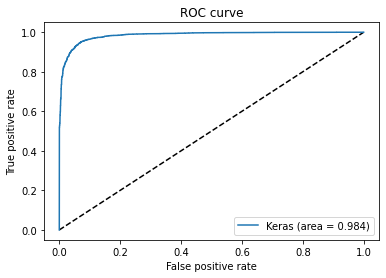

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

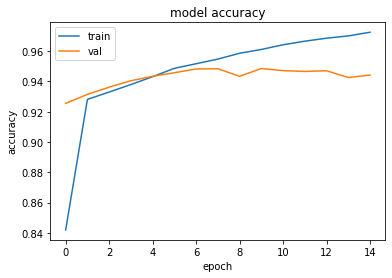

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()